In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [3]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [5]:
np.random.seed(0)

In [6]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [8]:
assert(X_train.shape[0]==y_train.shape[0]), "The number of training images are not equal to the number of labels"
assert(X_val.shape[0]==y_val.shape[0]), "The number of validation images are not equal to the number of labels"
assert(X_test.shape[0]==y_test.shape[0]), "The number of testing images are not equal to the number of labels"
assert(X_train.shape[1:]==(32,32,3)), "The dimension of images are not 32*32*3"
assert(X_val.shape[1:]==(32,32,3)), "The dimension of images are not 32*32*3"
assert(X_test.shape[1:]==(32,32,3)), "The dimension of images are not 32*32*3"

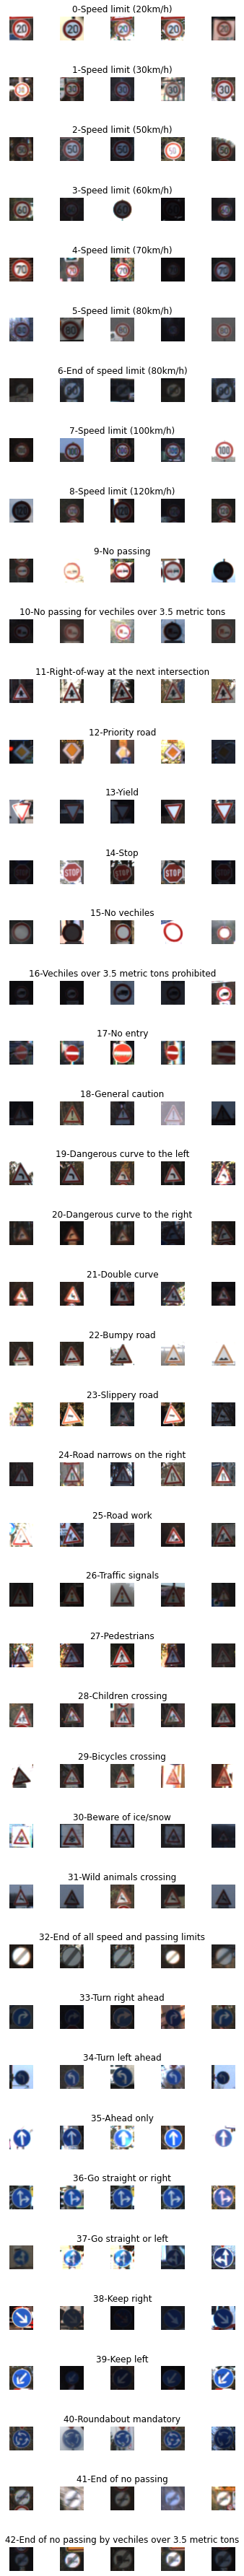

In [9]:
data = pd.read_csv("german-traffic-signs/signnames.csv")

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

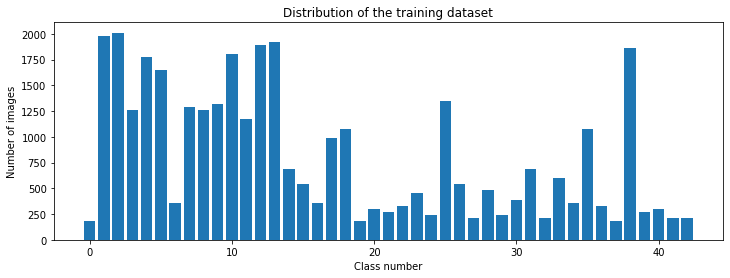

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


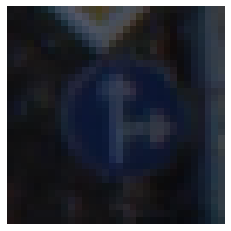

In [11]:
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


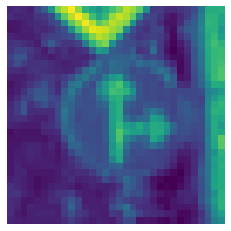

In [12]:
# convert colored image to gray scale

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


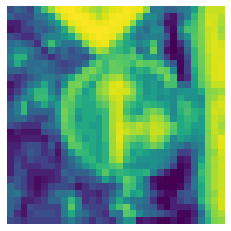

In [13]:
# Histogram equalizing aims to standarize lighting in all our images
# after histogram equalization all images will have same lighting effect
# img which we pass as an argument is only gray image hence RGB TO gray conversion become necessary

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

(34799, 32, 32)


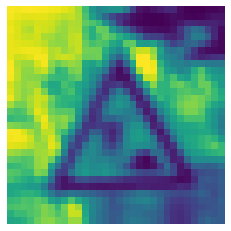

In [14]:
# This preprocessing function is defined to apply the technique of image conversion and histogram equalization on all our images

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255         # normalization
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [15]:
# adding depth in the image

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [16]:
# image data generator class: Type of transformations that we can make to our image
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

(15, 32, 32, 1)


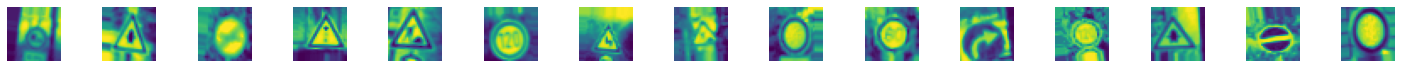

In [17]:
# creating new data images

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches) # to get our new batch of 15 images
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape) # these are the brand new 15 images that the image generator has created
# new batch of images are transformed : either zoomed in, with some shear angle, rotation_range etc wrt original image

In [18]:
# one hot encoding for multiple classes

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [19]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu')) # Conv2D("num of filters", "size of filters", input_shape, activation)
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu')) # adding 500 nodes in our hidden layer
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [20]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

In [21]:
history = model.fit(X_train, y_train, batch_size=50, epochs=10, validation_data=(X_val, y_val), verbose = 1, shuffle = 1)

Epoch 1/10
696/696 [==============================] - 4s 5ms/step - loss: 1.1739 - accuracy: 0.6669 - val_loss: 0.2143 - val_accuracy: 0.9308
Epoch 2/10
696/696 [==============================] - 3s 5ms/step - loss: 0.3032 - accuracy: 0.9046 - val_loss: 0.1137 - val_accuracy: 0.9671
Epoch 3/10
696/696 [==============================] - 4s 5ms/step - loss: 0.2076 - accuracy: 0.9345 - val_loss: 0.1407 - val_accuracy: 0.9576
Epoch 4/10
696/696 [==============================] - 4s 5ms/step - loss: 0.1555 - accuracy: 0.9518 - val_loss: 0.1109 - val_accuracy: 0.9696
Epoch 5/10
696/696 [==============================] - 4s 5ms/step - loss: 0.1383 - accuracy: 0.9580 - val_loss: 0.1185 - val_accuracy: 0.9701
Epoch 6/10
696/696 [==============================] - 4s 5ms/step - loss: 0.1256 - accuracy: 0.9605 - val_loss: 0.0723 - val_accuracy: 0.9746
Epoch 7/10
696/696 [==============================] - 3s 5ms/step - loss: 0.1058 - accuracy: 0.9666 - val_loss: 0.0644 - val_accuracy: 0.9810
Epoch 

Text(0.5, 0, 'epoch')

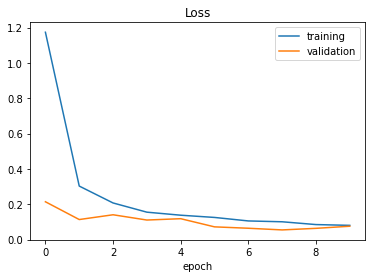

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

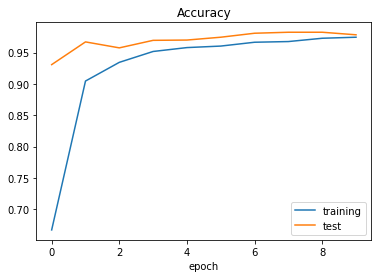

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.16215065121650696
Test accuracy: 0.9551860690116882


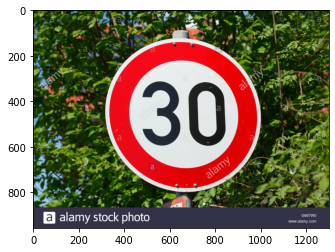

In [25]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


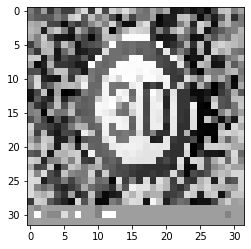

In [26]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [27]:
print("predicted sign: "+ str(model.predict_classes(img)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
predicted sign: [1]
